In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
import seaborn

import logging
logging.basicConfig(level=logging.INFO)


from robo.models.lcnet.basis_functions import vapor_pressure, exponential, hill_3, log_power, pow_func
from robo.models.lcnet import LCNet, get_lc_net


seaborn.set_style(style='whitegrid')

plt.rc('text', usetex=True)
plt.rc('font', size=15.0, family='serif')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

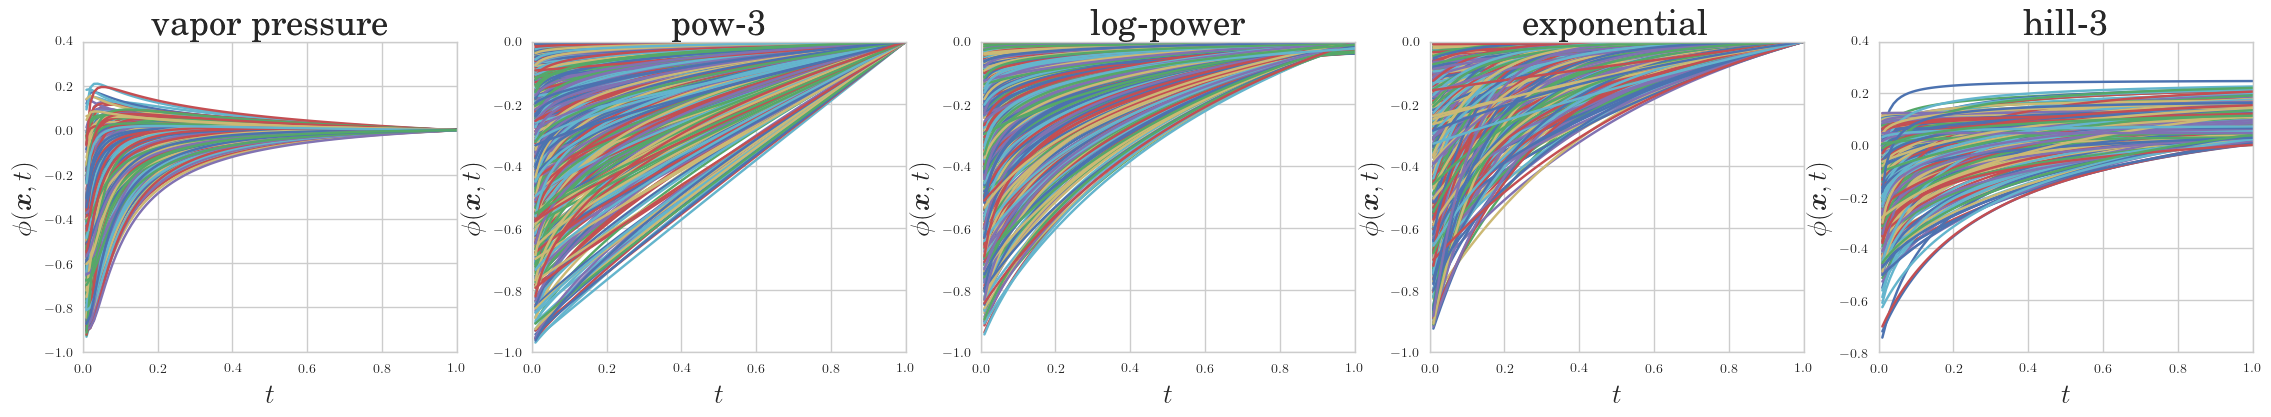

In [2]:
n_epochs = 100
N = 500
t_grid = np.linspace(1, n_epochs, n_epochs) / n_epochs


fig = plt.figure(figsize=(28,4))
ax1 = fig.add_subplot(1,5,1)
ax2 = fig.add_subplot(1,5,2)
ax3 = fig.add_subplot(1,5,3)
ax4 = fig.add_subplot(1,5,4)
ax5 = fig.add_subplot(1,5,5)

for i in range(N):
    theta = np.random.rand(13)
    phi = [vapor_pressure(t, theta[0], theta[1], theta[2]) for t_idx, t in enumerate(t_grid)]

    ax1.plot(t_grid, phi)
    ax1.set_xlabel(r"$t$", fontsize=20)
    ax1.set_ylabel(r"$\phi(\boldsymbol{x}, t)$", fontsize=20)
    ax1.set_title("vapor pressure", fontsize=25)

    phi = [pow_func(t, theta[3], theta[4]) for t_idx, t in enumerate(t_grid)]

    ax2.plot(t_grid, phi)
    ax2.set_xlabel(r"$t$", fontsize=20)
    ax2.set_ylabel(r"$\phi(\boldsymbol{x}, t)$", fontsize=20)
    ax2.set_title("pow-3", fontsize=25)

    phi = [log_power(t, theta[5], theta[6], theta[7]) for t_idx, t in enumerate(t_grid)]

    ax3.plot(t_grid, phi)
    ax3.set_xlabel(r"$t$", fontsize=20)
    ax3.set_ylabel(r"$\phi(\boldsymbol{x}, t)$", fontsize=20)
    ax3.set_title("log-power", fontsize=25)

    phi = [exponential(t, theta[8], theta[9]) for t_idx, t in enumerate(t_grid)]

    ax4.plot(t_grid, phi)
    ax4.set_xlabel(r"$t$", fontsize=20)
    ax4.set_ylabel(r"$\phi(\boldsymbol{x}, t)$", fontsize=20)
    ax4.set_title("exponential", fontsize=25)  

    phi = [hill_3(t, theta[10], theta[11], theta[12]) for t_idx, t in enumerate(t_grid)]

    ax5.plot(t_grid, phi)
    ax5.set_xlabel(r"$t$", fontsize=20)
    ax5.set_ylabel(r"$\phi(\boldsymbol{x}, t)$", fontsize=20)
    ax5.set_title("hill-3", fontsize=25)  

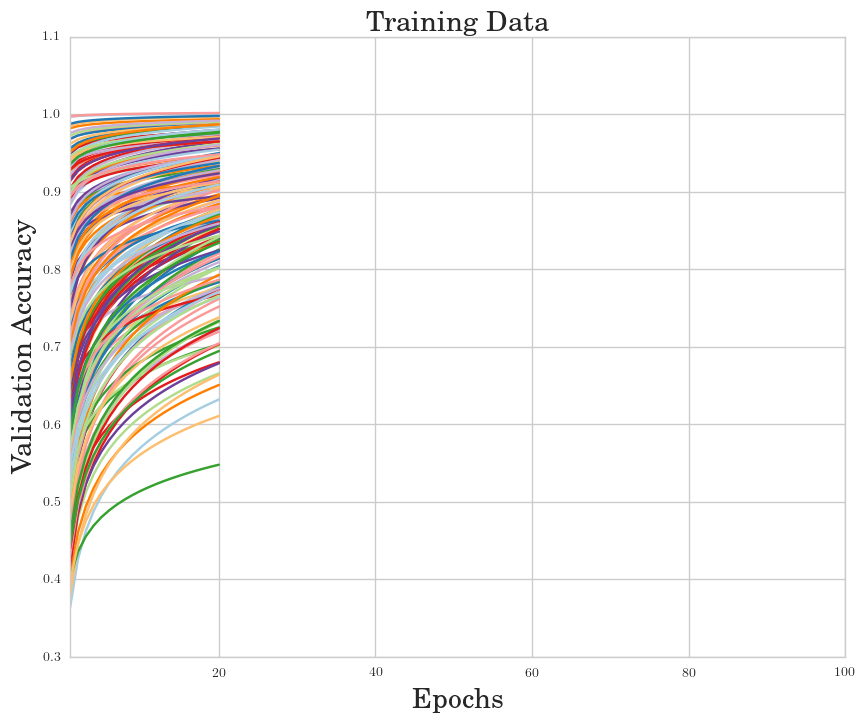

In [3]:
def toy_example(t, a, b):
    return (10 + a * np.log(b * t)) / 10. + 10e-3 * np.random.rand()

current_palette = seaborn.color_palette("Paired", 10)
seaborn.set_palette(current_palette)

observed = 20
N = 200
n_epochs = 100
observed_t = int(n_epochs * (observed / 100.))

t_idx = np.arange(1, observed_t + 1) / n_epochs
t_grid = np.arange(1, n_epochs + 1) / n_epochs

configs = np.random.rand(N, 2)
learning_curves = [toy_example(t_grid, configs[i, 0], configs[i, 1]) for i in range(N)]


X_train = None
y_train = None
X_test = None
y_test = None

for i in range(N):

    x = np.repeat(configs[i, None, :], t_idx.shape[0], axis=0)
    x = np.concatenate((x, t_idx[:, None]), axis=1)

    x_test = np.concatenate((configs[i, None, :], np.array([[1]])), axis=1)

    lc = learning_curves[i][:observed_t]
    lc_test = np.array([learning_curves[i][-1]])

    if X_train is None:
        X_train = x
        y_train = lc
        X_test = x_test
        y_test = lc_test
    else:
        X_train = np.concatenate((X_train, x), 0)
        y_train = np.concatenate((y_train, lc), 0)
        X_test = np.concatenate((X_test, x_test), 0)
        y_test = np.concatenate((y_test, lc_test), 0)        
    
    plt.plot(t_idx * n_epochs, lc)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.title("Training Data", fontsize=20)  
plt.xlim(1, n_epochs)
plt.show()

In [4]:
model = LCNet(sampling_method="sghmc",
              l_rate=np.sqrt(1e-4),
              mdecay=.05,
              n_nets=100,
              burn_in=5000,
              n_iters=30000,
              get_net=get_lc_net,
              precondition=True)

model.train(X_train, y_train)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
INFO:root:Starting sampling


... compiling theano function


INFO:root:Iter        0 : NLL =  2.8682e+00 MSE = 3.2122e-01 Time = 12.32
INFO:root:Iter      512 : NLL = -3.6275e+00 MSE = 2.8227e-04 Time = 13.85
INFO:root:Iter     1024 : NLL = -4.0308e+00 MSE = 1.6477e-04 Time = 15.43
INFO:root:Iter     1536 : NLL = -4.2248e+00 MSE = 2.0352e-04 Time = 17.27
INFO:root:Iter     2048 : NLL = -4.1989e+00 MSE = 1.4375e-04 Time = 18.87
INFO:root:Iter     2560 : NLL = -4.3585e+00 MSE = 1.4744e-04 Time = 20.54
INFO:root:Iter     3072 : NLL = -4.3997e+00 MSE = 9.3837e-05 Time = 22.17
INFO:root:Iter     3584 : NLL = -4.4361e+00 MSE = 8.8999e-05 Time = 24.61
INFO:root:Iter     4096 : NLL = -4.2700e+00 MSE = 1.4923e-04 Time = 26.70
INFO:root:Iter     4608 : NLL = -4.1860e+00 MSE = 1.4302e-04 Time = 28.48


... compiling theano function


INFO:root:Iter     5000 : NLL = -4.2933e+00 MSE = 8.1963e-05 Samples= 1 Time = 35.20
INFO:root:Iter     5100 : NLL = -4.4471e+00 MSE = 7.4091e-05 Samples= 2 Time = 35.48
INFO:root:Iter     5200 : NLL = -4.5344e+00 MSE = 7.5038e-05 Samples= 3 Time = 35.77
INFO:root:Iter     5300 : NLL = -4.4351e+00 MSE = 1.4156e-04 Samples= 4 Time = 36.03
INFO:root:Iter     5400 : NLL = -4.4876e+00 MSE = 8.4800e-05 Samples= 5 Time = 36.31
INFO:root:Iter     5500 : NLL = -4.2676e+00 MSE = 2.2038e-04 Samples= 6 Time = 36.59
INFO:root:Iter     5600 : NLL = -3.9226e+00 MSE = 1.7672e-04 Samples= 7 Time = 36.87
INFO:root:Iter     5700 : NLL = -4.4651e+00 MSE = 9.3725e-05 Samples= 8 Time = 37.15
INFO:root:Iter     5800 : NLL = -4.5362e+00 MSE = 9.0954e-05 Samples= 9 Time = 37.42
INFO:root:Iter     5900 : NLL = -4.5964e+00 MSE = 7.5791e-05 Samples= 10 Time = 37.70
INFO:root:Iter     6000 : NLL = -4.4253e+00 MSE = 9.8829e-05 Samples= 11 Time = 37.98
INFO:root:Iter     6100 : NLL = -4.4162e+00 MSE = 9.4607e-05 Sa

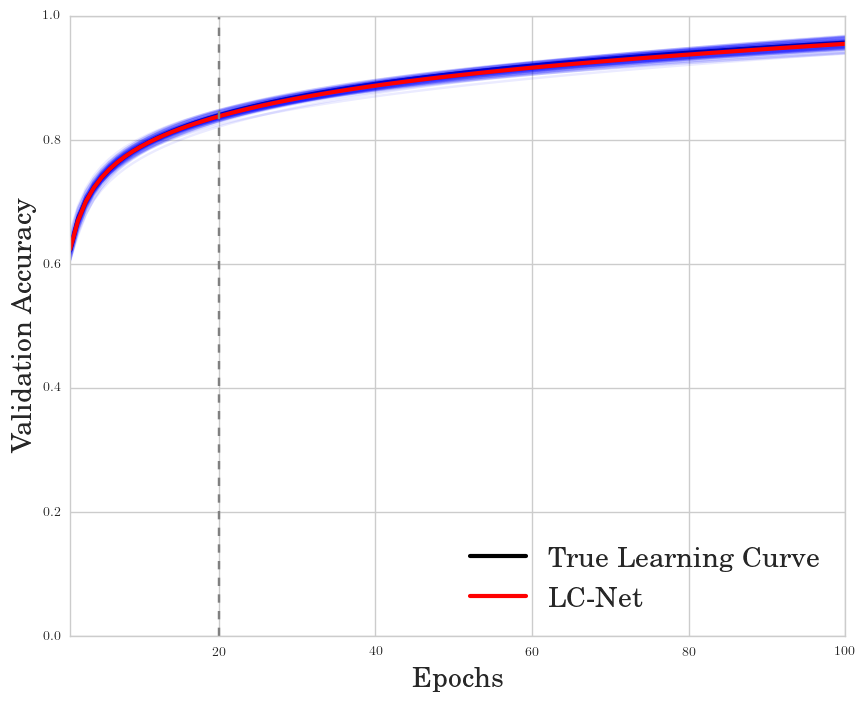

In [13]:
test_config = 9
x = configs[test_config, None, :]
epochs = np.arange(1, n_epochs+1)
idx = epochs / n_epochs
x = np.repeat(x, idx.shape[0], axis=0)
x = np.concatenate((x, idx[:, None]), axis=1)
y_test = learning_curves[test_config].flatten()

m, v = model.predict(x)
s = np.sqrt(v)
plt.plot(epochs, y_test, color="black", label="True Learning Curve", linewidth=3)


f, noise = model.predict(x, return_individual_predictions=True)

[plt.plot(epochs, fi, color="blue", alpha=0.08) for fi in f]


plt.plot(epochs, m, color="red", label="LC-Net", linewidth=3)
plt.legend(loc=4, fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.xlim(1, n_epochs)
plt.axvline(observed_t, linestyle="--", color="grey")
plt.ylim(0, 1)
plt.show()


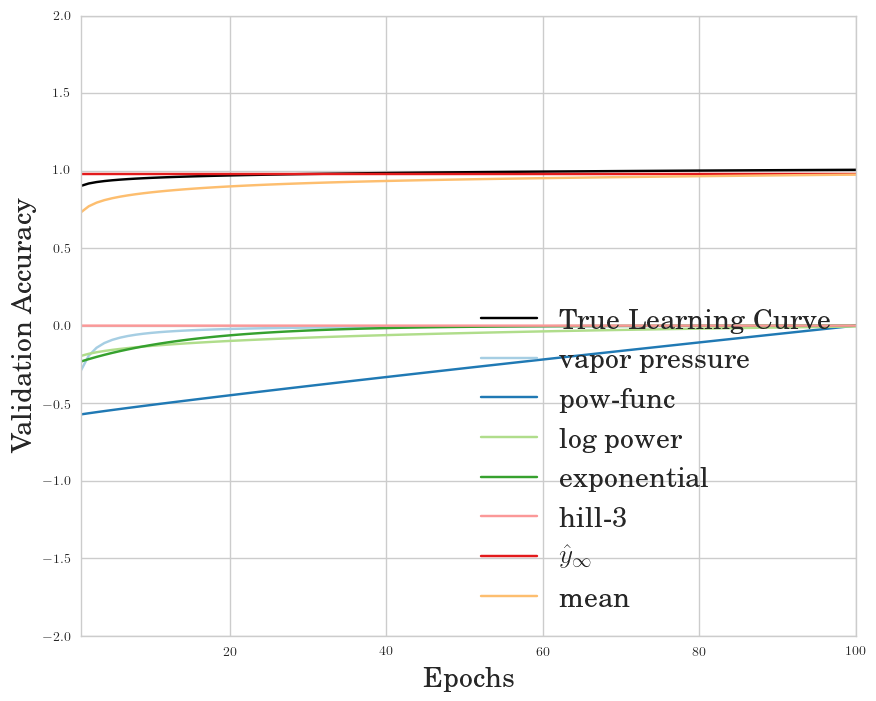

In [6]:
l = lasagne.layers.get_all_layers(model.net)[:-7]
bf = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, y_test, color="black", label="True Learning Curve")
plt.plot(epochs, bf[:, 0], label="vapor pressure")
plt.plot(epochs, bf[:, 1], label="pow-func")
plt.plot(epochs, bf[:, 2], label="log power")
plt.plot(epochs, bf[:, 3], label="exponential")
plt.plot(epochs, bf[:, 4], label="hill-3")

l = lasagne.layers.get_all_layers(model.net)[:-3]
infty = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, infty[:, 0], label=r"$\hat{y}_{\infty}$")

l = lasagne.layers.get_all_layers(model.net)[:-2]
mean = lasagne.layers.get_output(l, x)[-1].eval()

plt.plot(epochs, mean[:, 0], label="mean")

plt.legend(loc=4, fontsize=20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Validation Accuracy", fontsize=20)
plt.xlim(1, n_epochs)
plt.ylim(-2, 2)
plt.show()

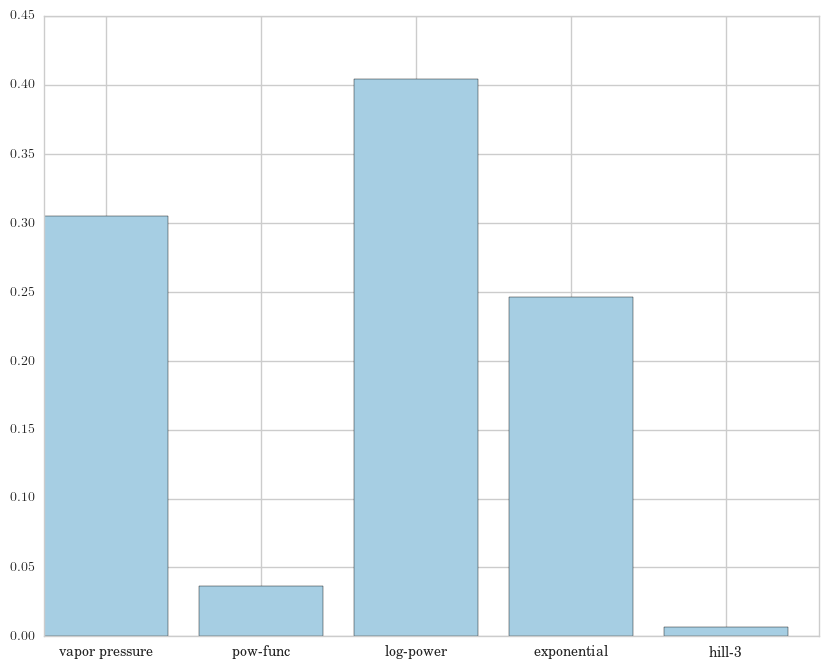

In [7]:
l = lasagne.layers.get_all_layers(model.net)[:-6]
weights = lasagne.layers.get_output(l, x)[-1].eval()

plt.bar(np.arange(5), weights[0])
plt.xticks(np.arange(5)+.4, ["vapor pressure", "pow-func", "log-power", "exponential", "hill-3"])
plt.show()